# setup

In [1]:
import gc
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from functools import lru_cache, partial
from typing import Iterable, Optional

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
from accelerate import Accelerator
from evaluate import load
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import as_stacked_batches
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.itertools import Cached, Cyclic
from gluonts.time_feature import (
    TimeFeature, get_lags_for_frequency,
    get_seasonality,
    time_features_from_frequency_str
)
from gluonts.transform import (
        AddAgeFeature, AddObservedValuesIndicator,
        AddTimeFeatures, AsNumpyArray, Chain,
        ExpectedNumInstanceSampler, InstanceSplitter,
        RemoveFields, RenameFields, SelectFields,
        SetField, TestSplitSampler, Transformation,
        ValidationSplitSampler, VstackFeatures
)
from gluonts.transform.sampler import InstanceSampler
from IPython.display import display
from pandas.core.arrays.period import period_array
from torch import nn
from torch.optim import AdamW
from transformers import (
    InformerConfig, InformerForPrediction,
    PretrainedConfig
)
from transformers.utils import send_example_telemetry
from datasets import load_dataset

In [2]:
plt.style.use('fivethirtyeight')

# data

In [3]:
df = pd.read_parquet("../data/01_raw/btc_raw_history_1d.parquet")
df["formatted_date"] = pd.to_datetime(df["formatted_date"])
df = df.sort_values(by="formatted_date")
df 

,date,high,low,open,close,volume,adjclose,formatted_date
0,1410912000,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,2014-09-17
1,1410998400,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,2014-09-18
2,1411084800,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,2014-09-19
3,1411171200,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,2014-09-20
4,1411257600,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,2014-09-21
...,...,...,...,...,...,...,...,...
3413,1705795200,41855.367188,41497.007812,41671.488281,41545.785156,9344043642,41545.785156,2024-01-21
3414,1705881600,41651.207031,39450.117188,41553.652344,39507.367188,31338708143,39507.367188,2024-01-22
3415,1705968000,40127.351562,38521.894531,39518.714844,39845.550781,29244553045,39845.550781,2024-01-23
3416,1706054400,40483.785156,39508.796875,39877.593750,40077.074219,22359526178,40077.074219,2024-01-24


In [4]:
THRESHOLD_INDEX = 365
train_dataset = df[["formatted_date", "close"]].set_index("formatted_date").iloc[:-THRESHOLD_INDEX].copy()
test_dataset = df[["formatted_date", "close"]].set_index("formatted_date").iloc[-THRESHOLD_INDEX:].copy()

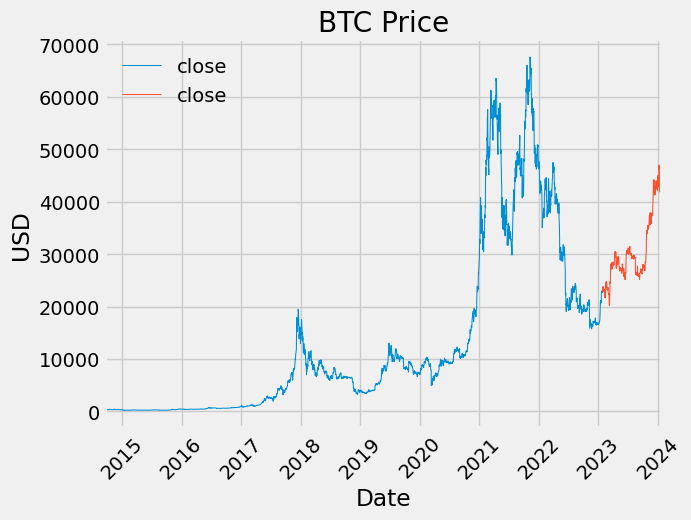

In [5]:
_, axs = plt.subplots(1, 1,)

train_dataset.plot(ax=axs, label="train", linewidth=0.75)
test_dataset.plot(ax=axs, label="test", linewidth=0.75)
axs.legend(frameon=False,)

axs.set_title("BTC Price")
axs.set_ylabel("USD")
axs.set_xlabel("Date")

for tick in axs.get_xticklabels():
    tick.set_rotation(45)

plt.show()

# training

## toy data

In [6]:
# dataset = load_dataset("monash_tsf", "traffic_hourly")
# KeyError: 'h'
# DatasetGenerationError: An error occurred while generating the dataset

# poetry update datasets solved it

dataset = load_dataset("monash_tsf", "traffic_hourly")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
})

In [8]:
train_example = dataset["train"][0]
train_example.keys()

validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [9]:
freq = "1H"
prediction_length = 48

assert len(train_example["target"]) + prediction_length == len(
    dataset["validation"][0]["target"]
)

In [10]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [11]:
gc.collect()

363

## functions

In [12]:
freq = "1D"
prediction_length = 24

In [13]:
send_example_telemetry(
    "lab_autoformer_01",
    framework="pytorch"
)

In [14]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [15]:
def probsparse_attention(query_states, key_states, value_states, sampling_factor=5):
    """
    Compute the probsparse self-attention.
    Input shape: Batch x Time x Channel

    Note the additional `sampling_factor` input.
    """
    # get input sizes with logs
    L_K = key_states.size(1)
    L_Q = query_states.size(1)
    log_L_K = np.ceil(np.log1p(L_K)).astype("int").item()
    log_L_Q = np.ceil(np.log1p(L_Q)).astype("int").item()

    # calculate a subset of samples to slice from K and create Q_K_sample
    U_part = min(sampling_factor * L_Q * log_L_K, L_K)

    # create Q_K_sample (the q_i * k_j^T term in the sparsity measurement)
    index_sample = torch.randint(0, L_K, (U_part,))
    K_sample = key_states[:, index_sample, :]
    Q_K_sample = torch.bmm(query_states, K_sample.transpose(1, 2))

    # calculate the query sparsity measurement with Q_K_sample
    M = Q_K_sample.max(dim=-1)[0] - torch.div(Q_K_sample.sum(dim=-1), L_K)

    # calculate u to find the Top-u queries under the sparsity measurement
    u = min(sampling_factor * log_L_Q, L_Q)
    M_top = M.topk(u, sorted=False)[1]

    # calculate Q_reduce as query_states[:, M_top]
    dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
    Q_reduce = query_states[dim_for_slice, M_top]  # size: c*log_L_Q x channel

    # and now, same as the canonical
    d_k = query_states.size(-1)
    attn_scores = torch.bmm(Q_reduce, key_states.transpose(-2, -1))  # Q_reduce x K^T
    attn_scores = attn_scores / math.sqrt(d_k)
    attn_probs = nn.functional.softmax(attn_scores, dim=-1)
    attn_output = torch.bmm(attn_probs, value_states)

    return attn_output, attn_scores

In [16]:
def informer_encoder_forward(x_input, num_encoder_layers=3, distil=True):
    # Initialize the convolution layers
    if distil:
        conv_layers = nn.ModuleList([ConvLayer() for _ in range(num_encoder_layers - 1)])
        conv_layers.append(None)
    else:
        conv_layers = [None] * num_encoder_layers

    # Apply conv_layer between each encoder_layer
    for encoder_layer, conv_layer in zip(encoder_layers, conv_layers):
        output = encoder_layer(x_input)
        if conv_layer is not None:
            output = conv_layer(loutput)

    return output

## preparation

In [17]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 862
})

In [18]:
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset)
    // num_of_variates,  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [19]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (862, 17448)


In [20]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [21]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7faa72d8c820>, <function day_of_month at 0x7faa72d8c940>, <function day_of_year at 0x7faa72d8ca60>]


In [22]:
timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


In [23]:
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [24]:
model.config.distribution_output


'student_t'

In [25]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [26]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [27]:

def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [28]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [29]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [30]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

In [31]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 216, 4]) torch.FloatTensor
past_values torch.Size([256, 216, 862]) torch.FloatTensor
past_observed_mask torch.Size([256, 216, 862]) torch.FloatTensor
future_time_features torch.Size([256, 24, 4]) torch.FloatTensor
future_values torch.Size([256, 24, 862]) torch.FloatTensor
future_observed_mask torch.Size([256, 24, 862]) torch.FloatTensor


In [32]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [33]:
print("Loss:", outputs.loss.item())

Loss: -1075.820068359375


In [34]:
epochs = 3
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    print(epoch)
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

0
-1071.9840087890625
1
-2222.6962890625
2
-2448.941650390625


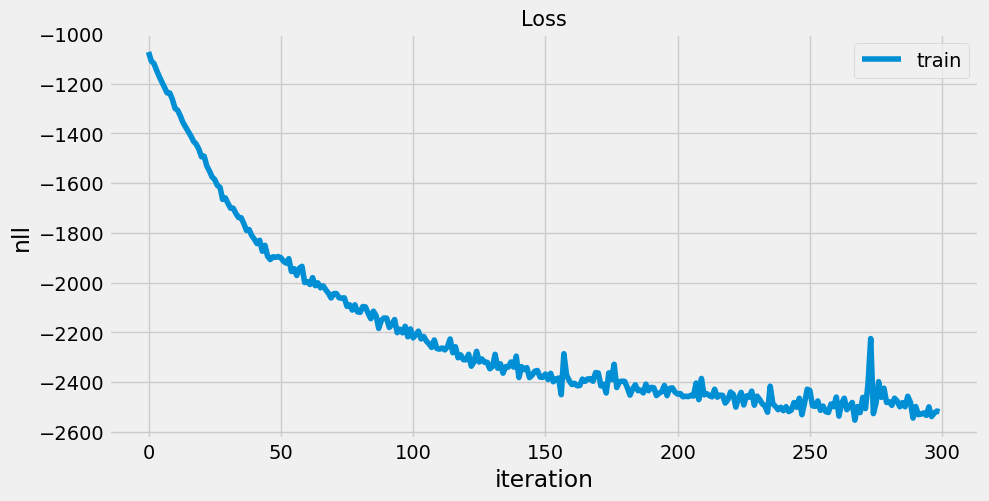

In [35]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [36]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

In [37]:
forecasts_[0].shape


(1, 100, 24, 862)

In [38]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 24, 862)


In [39]:
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [40]:
print(f"MASE: {np.mean(mase_metrics)}")


MASE: 1.5410710606194211


In [41]:
print(f"sMAPE: {np.mean(smape_metrics)}")


sMAPE: 0.6092617256963198


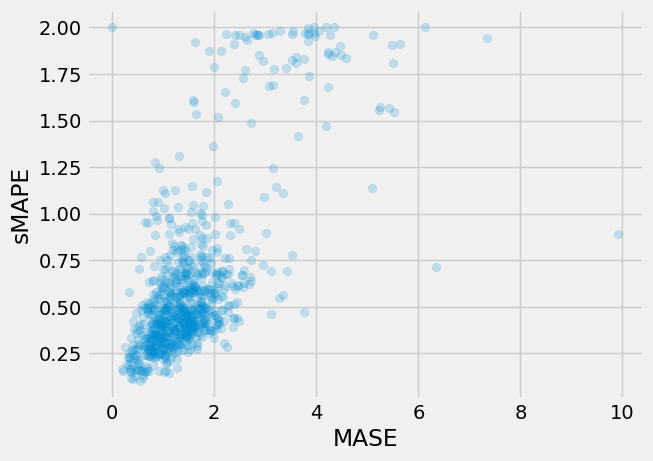

In [42]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [43]:
def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][
            mv_index, -2 * prediction_length :
        ],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()

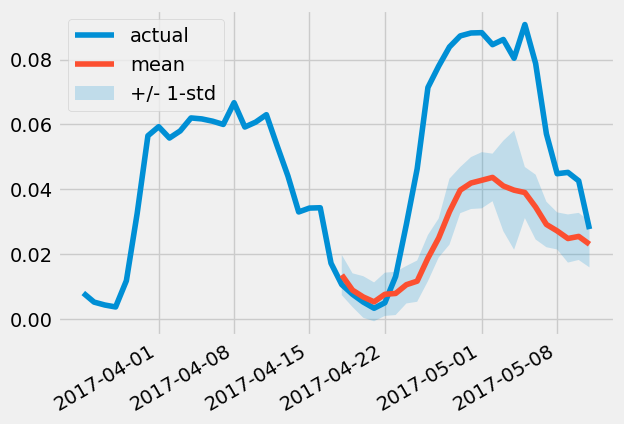

In [45]:
plot(0, 344) ;

refs:
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb
- https://github.com/huggingface/notebooks/blob/main/examples/multivariate_informer.ipynb

.